In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('../../..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import numpy as np
import tensorflow as tf

import ND_north_star.src.noise_generators.perlin_noise_generator as PNG # type: ignore
import ND_north_star.src.edge_detection.gradient_detection as ED_sim # type: ignore
from ND_north_star.src.utils.sampling_function import random_sampler # type: ignore
from ND_north_star.src.data_fillers.kNN_filler import kNN_data_filler # type: ignore

In [3]:
tf.config.list_physical_devices('GPU')

[]

Disable GPU

In [4]:
tf.config.set_visible_devices([], 'GPU')

## Generate dataset

In [5]:
resolution = 30
octaves = 4
dataset_size = 1024
drop_percs = [x/100 for x in range(0, 100, 5)]

In [6]:
data_path = "data/"
if not os.path.exists(data_path):
    os.makedirs(data_path)
data_path = "data/"

In [7]:
# dataset = np.array([PNG.ND_perlin_matrix([resolution, resolution], octaves=octaves, noise_cutoff_list=[0.5, 0, 1]) for _ in range(dataset_size)])
# np.save(data_path+'{resolution}x{resolution}_{octaves}_{dataset_size}_dataset.npy'.format(resolution=resolution, octaves=octaves, dataset_size=dataset_size), dataset)

In [8]:
dataset = np.load(data_path+'{resolution}x{resolution}_{octaves}_{dataset_size}_dataset.npy'.format(resolution=resolution, octaves=octaves, dataset_size=dataset_size))

In [9]:
from sklearn.preprocessing import MinMaxScaler

def perlin_M_to_dict(dimension_resolution, octaves, perlin_matrix):
    
    # Convert list to numpy array if needed
    array = np.array(perlin_matrix)
    shape = array.shape
 
    # Generate all possible coordinates in the N-dimensional array
    coordinates = np.indices(shape).reshape(len(shape), -1).T
    data = []      
    # Iterate over the coordinates and get the corresponding values
    for coord in coordinates:
        value = array[tuple(coord)]
        data.append(list(coord) + [value])
    
    # Separate the features and the value column
    features = [d[:-1] for d in data]
    values = [d[-1] for d in data]
    
    # Normalize the feature columns
    scaler = MinMaxScaler()
    normalized_features = scaler.fit_transform(features)
    
    # Create the output dictionary
    perlin_dict = {
        'features': normalized_features.tolist(),
        'values': values,
        'resolution': dimension_resolution,
        'coordinates': [f'x{i}' for i in range(len(shape))],
        'octaves': octaves,
        'dimension': len(dimension_resolution),
    }
    
    return perlin_dict

In [10]:
dict_dataset = [perlin_M_to_dict([resolution, resolution], octaves, m) for m in dataset]

In [11]:
X = [None for _ in range(len(drop_percs))]
for i, drop_perc in enumerate(drop_percs):
    X[i] = np.array([random_sampler(d, int(resolution*resolution*(1-drop_perc))) for d in dict_dataset])

Use knn to fill.

In [12]:
X_filled = np.zeros((len(drop_percs), dataset_size, resolution, resolution))
for i, drop_perc in enumerate(drop_percs):
    for j in range(dataset_size):
        dict = kNN_data_filler(X[i][j], rounding_threshold=0.9)
        for k in range(resolution*resolution):
            coords = np.round(dict['features']*(resolution-1))[k].astype(int)
            X_filled[i][j][coords[0]][coords[1]] = dict['values'][k]

Use gradient edge detection to generate edges.

In [13]:
y = np.array([ED_sim.gradient_edge_detection(dataset[i]) for i in range(dataset_size)]).astype(int)

## Train test split

In [14]:
from sklearn.model_selection import train_test_split

In [15]:
indices_train = [0 for _ in range(len(drop_percs))]
indices_test = [0 for _ in range(len(drop_percs))]

In [16]:
seed = 3834
for i in range(len(drop_percs)):
    indices_train[i], indices_test[i] = train_test_split(range(dataset_size), random_state=seed+i)

## CNN

In [17]:
from tensorflow import keras
from keras import models
from keras import layers
from sklearn.metrics import mean_squared_error

In [18]:
model_path = "checkpoints/"
if not os.path.exists(model_path):
    os.makedirs(model_path)

In [19]:
def weighted_cross_entropy(y_true, y_pred):
    y_pred = tf.cast(y_pred, tf.float32)
    y_pred = tf.where(tf.equal(y_pred, 0), tf.ones_like(y_pred)*1e-7, y_pred)
    y_pred = tf.where(tf.equal(y_pred, 1), tf.ones_like(y_pred)*(1-1e-7), y_pred)

    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    a = tf.reduce_sum(y_true_f)/y_true_f.shape[0]
    b = 1 - a
    return -a*tf.experimental.numpy.inner(1-y_true_f, tf.math.log(1-y_pred_f))-b*tf.experimental.numpy.inner(y_true_f, tf.math.log(y_pred_f))

In [20]:
epochs = 100
batch_size = 32

history = [None for _ in range(len(drop_percs))]
pred_continuous = [None for _ in range(len(drop_percs))]
threshold = 0.5
pred_discrete = [None for _ in range(len(drop_percs))]
wces = np.zeros(len(drop_percs))
mses = np.zeros(len(drop_percs))

for i, drop_perc in enumerate(drop_percs):
    model = models.Sequential([
        layers.InputLayer((resolution,resolution,1,)),
        layers.Conv2D(32, (3,3), activation='relu', padding = 'same'),
        layers.Conv2D(64, (3,3), activation='relu', padding='same'),
        layers.MaxPooling2D((2,2)),
        layers.Conv2DTranspose(32, (3,3), strides=2, activation='relu', padding='same'),
        layers.Conv2DTranspose(1, (3,3), activation='sigmoid', padding='same')
    ])
    model.compile(optimizer='adam',
                    # loss='mse',
                    loss=weighted_cross_entropy,
                    # loss='categorical_crossentropy',
                    metrics=['mse'])

    X_train = X_filled[i][indices_train[i]]
    y_train = y[indices_train[i]]
    X_test = X_filled[i][indices_test[i]]
    y_test = y[indices_test[i]]

    X_train_tensor = tf.convert_to_tensor(X_train)
    y_train_tensor = tf.convert_to_tensor(y_train)
    X_test_tensor = tf.convert_to_tensor(X_test)
    y_test_tensor = tf.convert_to_tensor(y_test)

    history[i] = model.fit(X_train_tensor, y_train_tensor, validation_data=(X_test_tensor, y_test_tensor),
                      epochs=epochs, 
                      batch_size=batch_size)

    model.save(model_path+"knn_filling_cnn_{resolution}x{resolution}_{octaves}_{dataset_size}_{drop_perc}_{epochs}.keras".format(resolution=resolution, octaves=octaves, dataset_size=dataset_size, drop_perc=drop_perc, epochs=epochs))

    pred_continuous[i] = model.predict(X_test_tensor)

    pred_discrete[i] = np.array([a>threshold for a in pred_continuous[i]]).reshape(y_test.shape).astype(int)

    mses[i] = np.mean([mean_squared_error(y_test[j], pred_discrete[i][j]) for j in range(len(y_test))])
    wces[i] = np.mean([weighted_cross_entropy(y_test[j], pred_discrete[i][j]) for j in range(len(y_test))])

Epoch 1/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 7007.9312 - mse: 0.2423 - val_loss: 5456.3228 - val_mse: 0.1769
Epoch 2/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 4458.6631 - mse: 0.1426 - val_loss: 2232.9263 - val_mse: 0.0720
Epoch 3/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1841.1226 - mse: 0.0560 - val_loss: 1111.6454 - val_mse: 0.0322
Epoch 4/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 976.4595 - mse: 0.0281 - val_loss: 660.0540 - val_mse: 0.0188
Epoch 5/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 585.6215 - mse: 0.0160 - val_loss: 416.4654 - val_mse: 0.0107
Epoch 6/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 377.5973 - mse: 0.0096 - val_loss: 277.9743 - val_mse: 0.0067
Epoch 7/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 246.6362 - mse: 0.0060 - val_loss: 195.2830 - val_mse: 0.0046
Epoch 8/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 174.8447 - mse: 0.0040 - val_loss: 145.5474 - val_mse: 0.0030
Epoch 9/100
24/24 

In [26]:
np.save(data_path+'knn_filling_cnn_{resolution}x{resolution}_{octaves}_{dataset_size}_{epochs}_pred.npy'.format(resolution=resolution, octaves=octaves, dataset_size=dataset_size, epochs=epochs), pred_continuous)

np.save(data_path+'knn_filling_cnn_{resolution}x{resolution}_{octaves}_{dataset_size}_{epochs}_mses.npy'.format(resolution=resolution, octaves=octaves, dataset_size=dataset_size, epochs=epochs), mses)

np.save(data_path+'knn_filling_cnn_{resolution}x{resolution}_{octaves}_{dataset_size}_{epochs}_wces.npy'.format(resolution=resolution, octaves=octaves, dataset_size=dataset_size, epochs=epochs), wces)

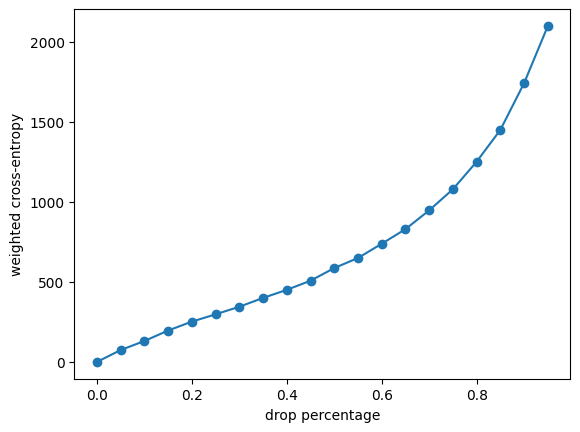

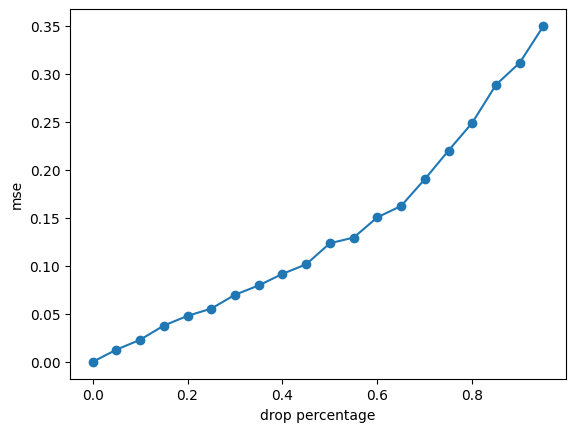

In [33]:
import matplotlib.pyplot as plt

plt.plot(drop_percs, wces, marker='o')
plt.xlabel("drop percentage")
plt.ylabel("weighted cross-entropy")
plt.show()

plt.plot(drop_percs, mses, marker='o')
plt.xlabel("drop percentage")
plt.ylabel("mse")
plt.show()

## Some visualization

In [30]:
d = 0.5 # drop ratio
n = 239
cmap = 'gray_r'

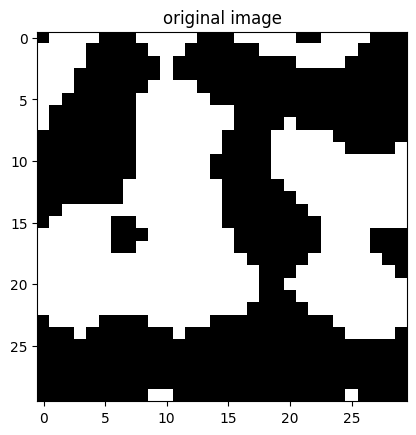

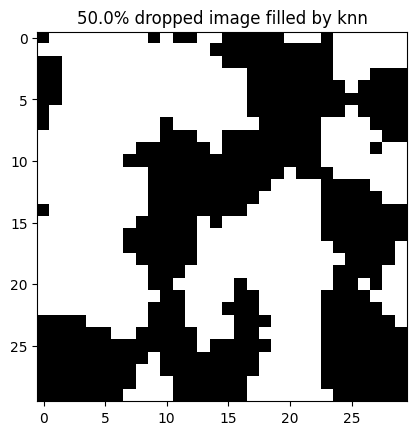

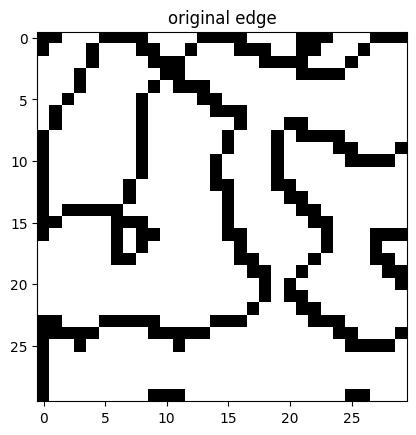

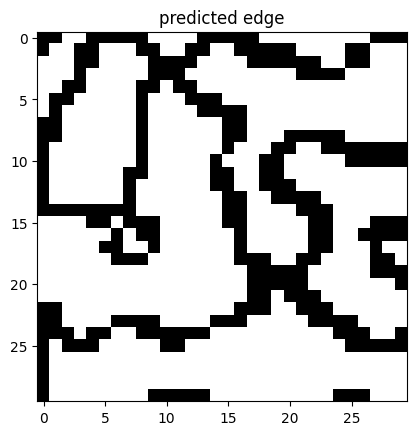

In [31]:
import matplotlib.pyplot as plt

m = drop_percs.index(d)
k = indices_test[drop_percs.index(d)][n]

plt.imshow(dataset[k], cmap=cmap)
plt.title("original image")
plt.show()
plt.imshow(X_filled[m][n], cmap=cmap)
plt.title("{drop_perc}% dropped image filled by knn".format(drop_perc = drop_percs[m]*100))
plt.show()
plt.imshow(y[indices_test[m]][n], cmap=cmap)
plt.title("original edge")
plt.show()
plt.imshow(pred_discrete[m][n], cmap=cmap)
plt.title("predicted edge")
plt.show()

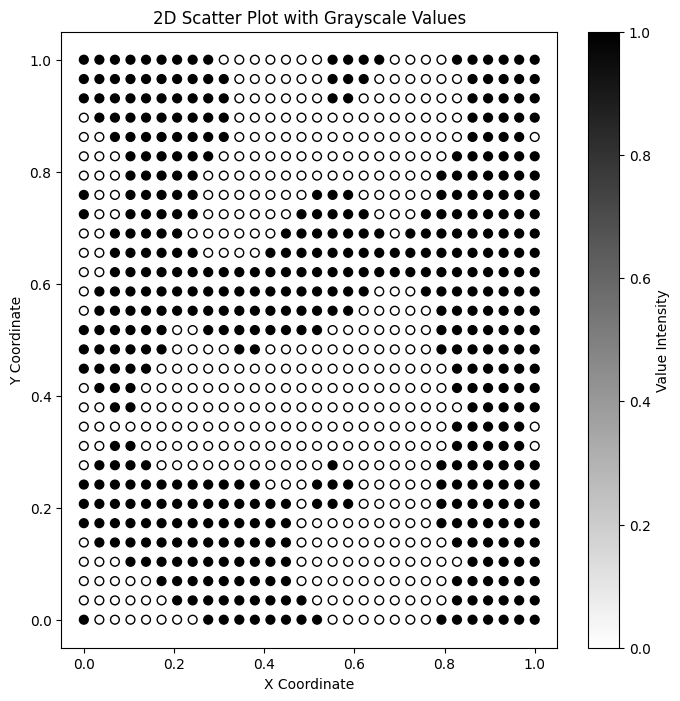

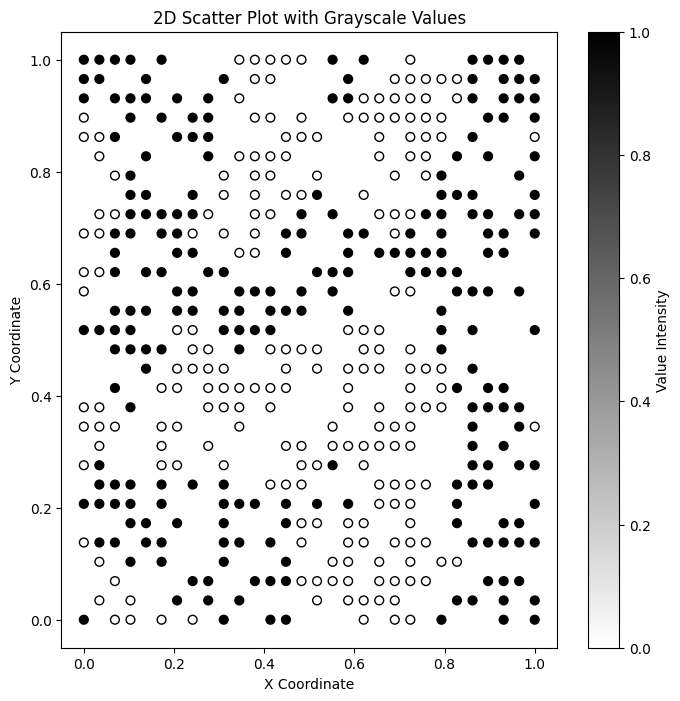

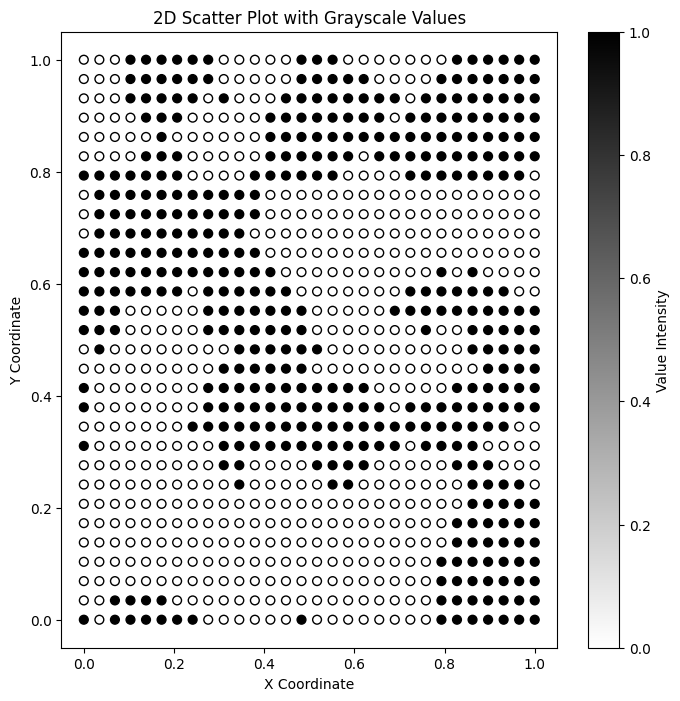

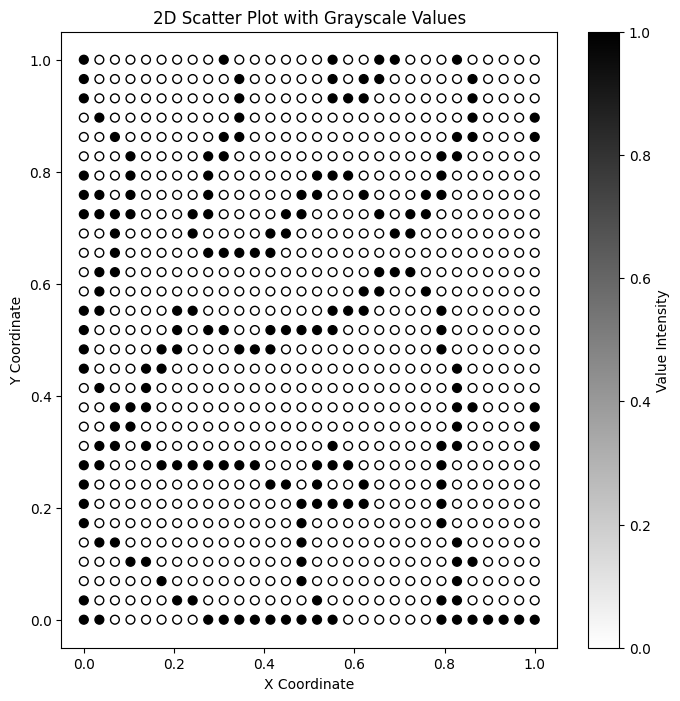

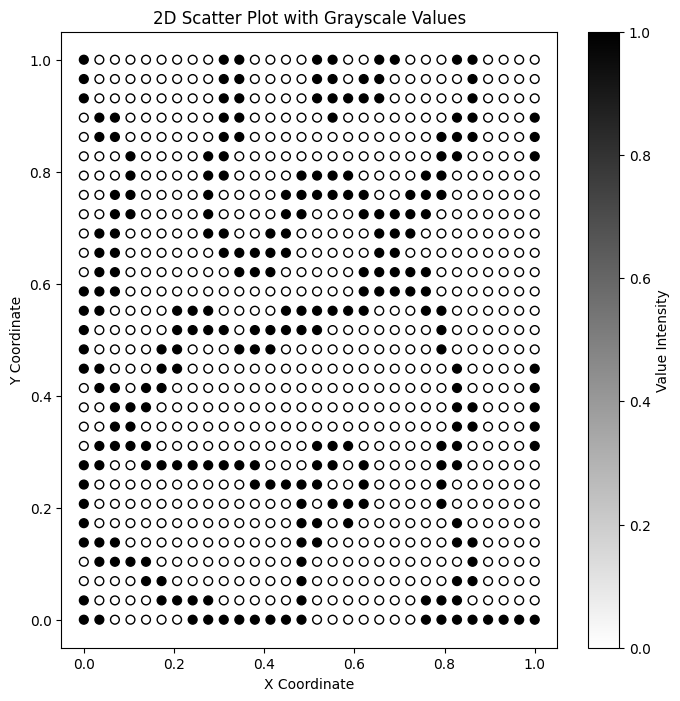

In [32]:
PNG.plot_perlin_2D_3D(perlin_M_to_dict([resolution, resolution], octaves, dataset[k]), cmap=cmap, edgecolors='black')
PNG.plot_perlin_2D_3D(np.array(X)[m][indices_test[m]][n], cmap=cmap, edgecolors='black')
PNG.plot_perlin_2D_3D(perlin_M_to_dict([resolution, resolution], octaves, X_filled[m][n]), cmap=cmap, edgecolors='black')
PNG.plot_perlin_2D_3D(perlin_M_to_dict([resolution, resolution], octaves, y[indices_test[m]][n]), cmap=cmap, edgecolors='black')
PNG.plot_perlin_2D_3D(perlin_M_to_dict([resolution, resolution], octaves, pred_discrete[m][n]), cmap=cmap, edgecolors='black')